<a href="https://colab.research.google.com/github/INCREDIBLE-AURNOB/Sentiment-analysis/blob/main/Sentiment_analysis_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet

In [2]:
import opendatasets as od

In [3]:
dataset='https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews'

In [4]:

od.download(dataset)

Skipping, found downloaded files in "./imdb-dataset-of-50k-movie-reviews" (use force=True to force download)


In [5]:
import os

In [6]:
data_dir='/content/imdb-dataset-of-50k-movie-reviews'
os.listdir(data_dir)

['IMDB Dataset.csv']

In [7]:
import pandas as pd

In [8]:
raw_df=pd.read_csv('/content/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
raw_df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## Preprocessing

In [9]:
import numpy as np
import torch
import torch.nn as nn
import  torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

In [10]:
is_cuda=torch.cuda.is_available()

if is_cuda:
  device=torch.device("cuda")
  print("GPU is available")
else:
  device=torch.device("cpu")
  print("CPU is available")

GPU is available


In [11]:
raw_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Spliting train and test set

In [12]:
x,y=raw_df['review'].values ,raw_df['sentiment']
x[:2],y[:2]

(array(["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due t

In [13]:

x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y)


In [14]:
x_train.shape,x_test.shape

((37500,), (12500,))

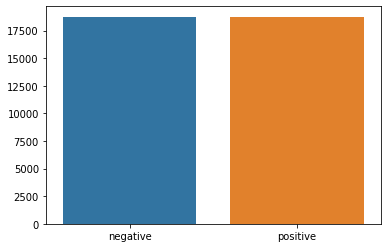

In [15]:
plot=pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=plot.values)
plt.show()

In [16]:
plot=pd.Series(y_train).value_counts(normalize=True)
plot

negative    0.5
positive    0.5
Name: sentiment, dtype: float64

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [19]:
x_train,y_train,x_test,y_test,vocab=tokenize(x_train,y_train,x_test,y_test)

<ipython-input-18-0919ce84a36f>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [20]:
len(vocab)

1000

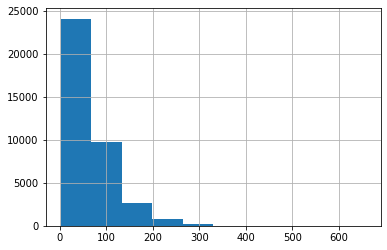

count    37500.00000
mean        69.20928
std         47.77947
min          2.00000
25%         39.00000
50%         54.00000
75%         84.00000
max        657.00000
dtype: float64

In [21]:
rev_len=[len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

## Padding
Pad to the max length

In [22]:
def padding_(sentences,seq_length):
  features=np.zeros((len(sentences),seq_length),dtype=int)
  for i,review in enumerate(sentences):
    if len(review)!=0:
      features[i,-len(review):]=np.array(review)[:seq_length]
  return features

In [23]:
x_train_pad=padding_(x_train,500)
x_test_pad=padding_(x_test,500)

Creating tensor dataset

In [24]:
train_data=TensorDataset(torch.from_numpy(x_train_pad),torch.from_numpy(y_train))
valid_data=TensorDataset(torch.from_numpy(x_test_pad),torch.from_numpy(y_test))

#dataloaders
batch_size=50
train_loader=DataLoader(train_data,shuffle=True,batch_size=batch_size)
valid_loader=DataLoader(valid_data,shuffle=True,batch_size=batch_size)

In [25]:
dataiter= iter(train_loader)
sample_x ,sample_y=next(dataiter)


In [26]:
print('Sample input size:',sample_x.size())
print('Sample input: ',sample_x)
print('Sample input : ',sample_y)

Sample input size: torch.Size([50, 500])
Sample input:  tensor([[  0,   0,   0,  ..., 110, 583, 240],
        [  0,   0,   0,  ...,   2, 727, 775],
        [  0,   0,   0,  ..., 449, 323, 526],
        ...,
        [  0,   0,   0,  ..., 162, 271, 204],
        [  0,   0,   0,  ..., 142,  22,  23],
        [  0,   0,   0,  ..., 766,  53,   1]])
Sample input :  tensor([0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 0])


## Model 

In [27]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [30]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Training


In [32]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [33]:
len(train_loader.dataset) , len(valid_loader.dataset)

(37500, 12500)

In [35]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        # torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.3982675444483757 val_loss : 0.357067954570055
train_accuracy : 82.28533333333333 val_accuracy : 84.944
Validation loss decreased (inf --> 0.357068).  Saving model ...
Epoch 2
train_loss : 0.32996904056270915 val_loss : 0.34388275295495985
train_accuracy : 85.98400000000001 val_accuracy : 85.432
Validation loss decreased (0.357068 --> 0.343883).  Saving model ...
Epoch 3
train_loss : 0.29318465109666186 val_loss : 0.3289127325415611
train_accuracy : 87.64266666666667 val_accuracy : 86.232
Validation loss decreased (0.343883 --> 0.328913).  Saving model ...
Epoch 4
train_loss : 0.25902291094263397 val_loss : 0.3394580869078636
train_accuracy : 89.33333333333333 val_accuracy : 85.232
Epoch 5
train_loss : 0.20880423082907995 val_loss : 0.34952822503447534
train_accuracy : 91.65333333333334 val_accuracy : 85.44800000000001


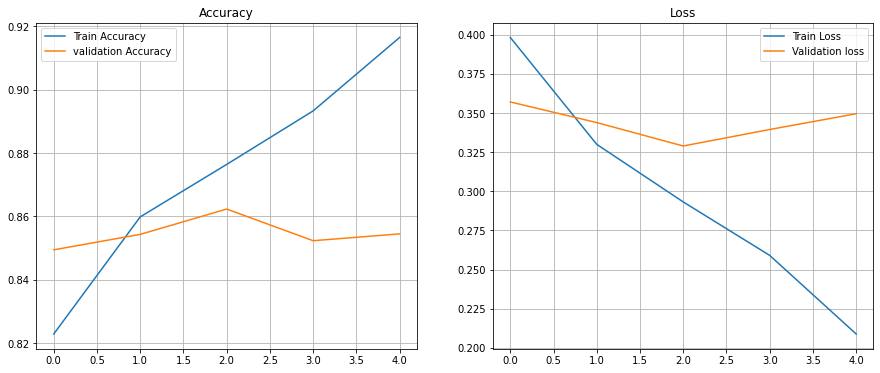

In [41]:
fig=plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(epoch_tr_acc,label="Train Accuracy")
plt.plot(epoch_vl_acc,label="validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epoch_tr_loss,label="Train Loss")
plt.plot(epoch_vl_loss,label="Validation loss")
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

## Prediction

In [42]:
def predict_text(text):
  word_seq=np.array([vocab[preprocess_string(word)] for word in text.split()
                    if preprocess_string(word) in vocab.keys()])
  word_seq=np.expand_dims(word_seq,axis=0)
  pad=torch.from_numpy(padding_(word_seq,5000))
  inputs=pad.to(device)
  batch_size=1
  h=model.init_hidden(batch_size)
  h=tuple([each.data for each in h])
  output,h=model(inputs,h)
  return (output.item())

In [45]:
index = 35
print(raw_df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {raw_df["sentiment"][index]}')
print('='*70)
pro = predict_text(raw_df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

I bought this film at Blockbuster for $3.00, because it sounded interesting (a bit Ranma-esque, with the idea of someone dragging around a skeleton), because there was a cute girl in a mini-skirt on the back, and because there was a Restricted Viewing sticker on it. I thought it was going to be a sweet or at least sincere coming of age story with a weird indie edge. I was 100% wrong.<br /><br />Having watched it, I have to wonder how it got the restricted sticker, since there is hardly any foul language, little violence, and the closest thing to nudity (Honestly! I don't usually go around hoping for it!) is when the girl is in her nightgown and you see her panties (you see her panties a lot in this movie, because no matter what, she's wearing a miniskirt of some sort). Even the anti-religious humor is tame (and lame, caricatured, insincere, derivative, unoriginal, and worst of all not funny in the slightest--it would be better just to listen to Ray Stevens' "Would Jesus Wear a Rolex on

In [46]:
index = 30
print(raw_df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {raw_df["sentiment"][index]}')
print('='*70)
pro = predict_text(raw_df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Taut and organically gripping, Edward Dmytryk's Crossfire is a distinctive suspense thriller, an unlikely "message" movie using the look and devices of the noir cycle.<br /><br />Bivouacked in Washington, DC, a company of soldiers cope with their restlessness by hanging out in bars. Three of them end up at a stranger's apartment where Robert Ryan, drunk and belligerent, beats their host (Sam Levene) to death because he happens to be Jewish. Police detective Robert Young investigates with the help of Robert Mitchum, who's assigned to Ryan's outfit. Suspicion falls on the second of the three (George Cooper), who has vanished. Ryan slays the third buddy (Steve Brodie) to insure his silence before Young closes in.<br /><br />Abetted by a superior script by John Paxton, Dmytryk draws precise performances from his three starring Bobs. Ryan, naturally, does his prototypical Angry White Male (and to the hilt), while Mitchum underplays with his characteristic alert nonchalance (his role, howeve